In [1]:
import numpy as np
import pandas as pd


FILES = ["links", "movies", "ratings", "tags"]
def load_data(path):
    # Load all data in a dict
    df_data = {}
    for filename in FILES:
        df_data[filename] = pd.read_csv(f'{path}/{filename}.csv', sep=",")
    return df_data
df_data = load_data('./data')

In [2]:
movies = df_data['movies']
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


### Keep only the users that rated more than a certain number of movies

In [3]:
ratings = df_data['ratings']
ratings


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [4]:
number_ratings = ratings.groupby('userId')['rating'].aggregate('size')
number_ratings = pd.DataFrame({'userId': number_ratings.index, f'number_ratings_user': number_ratings.values})
number_ratings

,userId,number_ratings_user
0,1,70
1,2,184
2,3,656
3,4,242
4,5,101
...,...,...
162536,162537,101
162537,162538,154
162538,162539,47
162539,162540,88


In [5]:
nb_movies_min = 1500
nb_movies_max = 3000

In [6]:
number_ratings = number_ratings[(number_ratings['number_ratings_user'] > nb_movies_min) & (number_ratings['number_ratings_user'] < nb_movies_max)]
number_ratings = number_ratings.drop(columns='number_ratings_user')
number_ratings

,userId
625,626
846,847
996,997
1400,1401
1651,1652
...,...
161183,161184
161382,161383
161543,161544
161585,161586


#### If there is still a lot of users, we remove some

In [7]:
seed=12
rng = np.random.RandomState(seed)
nb_users = 1000
if nb_users < number_ratings.shape[0]:
    user_ids = rng.choice(number_ratings['userId'].unique(), nb_users)
    users_x_movies = number_ratings[number_ratings['userId'].isin(user_ids)]
    users_x_movies
else:
    nb_users = number_ratings.shape[0]
nb_users

786

In [8]:
ratings = pd.merge(ratings, number_ratings, on='userId')
ratings

,userId,movieId,rating,timestamp
0,626,1,4.5,1136304145
1,626,2,4.0,954443171
2,626,7,4.5,1124158857
3,626,8,3.0,954443027
4,626,10,4.0,953847682
...,...,...,...,...
1542045,161928,157075,3.0,1464509884
1542046,161928,157363,3.5,1464509655
1542047,161928,157365,3.5,1464509616
1542048,161928,158428,3.0,1464509159


In [9]:
def get_year(title):
    idx = title.rfind('(') + 1
    try:
        return int(title[idx:idx+4])
    except ValueError:
        print(title, end='\t')
        return -1

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
def extract_features(movies, ratings, id_column):
    features = None
    movies = movies.copy()
    ratings = ratings.copy().drop(['timestamp'], axis=1)
    name = None
    if id_column == 'movieId':
        name = 'movie_'
        features = movies.copy()
    
        # Create year column
        features['year'] = features['title'].map(get_year)

        # Drop title
        features.drop('title', inplace=True, axis=1)

        # Encode genres
        features['genres'] = features['genres'].apply(lambda x: x.split('|'))
        mlb = MultiLabelBinarizer()
        features = features.join(pd.DataFrame(mlb.fit_transform(features.pop('genres')),
                                columns=mlb.classes_,
                                index=features.index))
    else:
        name = ''
        features = ratings.copy()

    # Stats ratings 
    stats = {}
    aggregates = ['mean', 'median', 'min', 'max', 'std', 'size']

    for agg in  aggregates:
        name_agg = 'number' if agg == 'size' else agg
        stats[agg] = ratings.groupby(id_column)['rating'].aggregate(agg)
        stats[agg] = pd.DataFrame({id_column: stats[agg].index, f'{name}{name_agg}_ratings': stats[agg].values})

    # Merging all dataframes
    for rating_stat in stats.values():
        features = pd.merge(features, rating_stat, on=id_column)
    
    # Replace NaN with 0
    features.fillna(0, inplace=True)

    # Add column index
    features[f'{name}index'] =  features.index

    return features

### Extract features of movies 
1) year 
2) Convert genres to vectors
3) mean, median, std, min, max of ratings of the movie

In [11]:
movies_features = extract_features(movies, ratings, 'movieId')
movies_features

Millions Game, The (Das Millionenspiel)	Terrible Joe Moran	The Court-Martial of Jackie Robinson	In Our Garden	Stephen Fry In America - New World	Two: The Story of Roman & Nyro	A Year Along the Abandoned Road	Body/Cialo	Polskie gówno	The Third Reich: The Rise & Fall	La vendetta dei barbari	My Own Man	Moving Alan	Zone 261	Michael Laudrup - en Fodboldspiller	Honky	Blueberry Hill	Pleasure Palace	Terror on the 40th Floor	My Boyfriend's Back	One Night Only	Doli Saja Ke Rakhna	The Dead Lands	C'mon, Let's Live a Little	For a Book of Dollars	Twins from Texas	Señorita Justice	Flash and Firecat	Red Victoria	Vaastupurush	Sierra Leone's Refugee All Stars	L'uomo della carità	The Big Fall	Wolves In The Snow	Amazon Falls	Dark Tides	The Ritual	The Expedition	Chinese Boxes	Danielův svět	The Near Room	Filmage: The Story of Descendents/All	About Sarah	La steppa	Swallows and Amazons	Ready Player One	Los tontos y los estúpidos	Ride in a Pink Car	The Naked Truth (1957) (Your Past Is Showing)	Disaster Playgro

,movieId,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,movie_mean_ratings,movie_median_ratings,movie_min_ratings,movie_max_ratings,movie_std_ratings,movie_number_ratings,movie_index
0,1,1995,0,0,1,1,1,1,0,0,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
1,2,1995,0,0,1,0,1,0,0,0,...,0,0,0,3.002555,3.0,0.5,5.0,0.930839,587,1
2,3,1995,0,0,0,0,0,1,0,0,...,0,0,0,2.742331,3.0,0.5,5.0,0.996696,326,2
3,4,1995,0,0,0,0,0,1,0,0,...,0,0,0,2.471154,3.0,0.5,5.0,1.037704,104,3
4,5,1995,0,0,0,0,0,1,0,0,...,0,0,0,2.574766,2.5,0.5,5.0,0.918908,321,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40387,209065,1906,1,0,0,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,40387
40388,209067,1896,1,0,0,0,0,0,0,0,...,0,0,0,2.500000,2.5,2.5,2.5,0.000000,1,40388
40389,209089,1902,1,0,0,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,40389
40390,209103,1991,1,0,0,0,0,0,0,0,...,0,0,0,4.000000,4.0,4.0,4.0,0.000000,1,40390


#### Remark

Initially, there are 59047 movies that have been rated (on a total of 62423 movies).

-- If we filter at the beginning the number of users (as it's done above), we keep only the movies rated by the users we kept, so there will be fewer movies again.

## One hot encoding of users

In [12]:
ratings_x_movies = pd.merge(ratings, movies_features, on="movieId")
ratings_x_movies

,userId,movieId,rating,timestamp,year,(no genres listed),Action,Adventure,Animation,Children,...,Thriller,War,Western,movie_mean_ratings,movie_median_ratings,movie_min_ratings,movie_max_ratings,movie_std_ratings,movie_number_ratings,movie_index
0,626,1,4.5,1136304145,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
1,847,1,4.0,1048092664,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
2,997,1,4.5,1529250285,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
3,1401,1,4.5,1544250123,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
4,1652,1,5.0,1503238932,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542045,161928,128231,3.0,1447095123,1971,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,22850
1542046,161928,144486,3.0,1452366365,1996,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,26468
1542047,161928,145992,3.5,1447095527,1982,0,0,0,0,0,...,0,0,0,3.500000,3.5,3.5,3.5,0.000000,1,26756
1542048,161928,147256,3.0,1450163549,1980,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,27079


In [13]:
path = f'./data/processed_ont_hot_movies_min={nb_movies_min}_movies_max={nb_movies_max}_users={nb_users}.csv'
ratings_x_movies.to_csv(path)


In [14]:
# title = 'processed_ont_hot_movies_min=1500_movies_max=3000_users=786.csv'
# title

In [15]:
import pandas as pd
data = pd.read_csv(path, sep=",", index_col=0, converters={'userId_x': pd.eval})

In [16]:
data

,userId,movieId,rating,timestamp,year,(no genres listed),Action,Adventure,Animation,Children,...,Thriller,War,Western,movie_mean_ratings,movie_median_ratings,movie_min_ratings,movie_max_ratings,movie_std_ratings,movie_number_ratings,movie_index
0,626,1,4.5,1136304145,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
1,847,1,4.0,1048092664,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
2,997,1,4.5,1529250285,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
3,1401,1,4.5,1544250123,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
4,1652,1,5.0,1503238932,1995,0,0,1,1,1,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542045,161928,128231,3.0,1447095123,1971,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,22850
1542046,161928,144486,3.0,1452366365,1996,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,26468
1542047,161928,145992,3.5,1447095527,1982,0,0,0,0,0,...,0,0,0,3.500000,3.5,3.5,3.5,0.000000,1,26756
1542048,161928,147256,3.0,1450163549,1980,0,0,0,0,0,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,27079


___
## For feature mapping users x movies
___

### Extract features of ratings of users
1) mean, median, std, min, max of ratings of the user

In [11]:
ratings_features = extract_features(movies, ratings, 'userId')
ratings_features

,userId,movieId,rating,mean_ratings,median_ratings,min_ratings,max_ratings,std_ratings,number_ratings,index
0,626,1,4.5,3.322034,3.5,0.5,5.0,0.850419,1888,0
1,626,2,4.0,3.322034,3.5,0.5,5.0,0.850419,1888,1
2,626,7,4.5,3.322034,3.5,0.5,5.0,0.850419,1888,2
3,626,8,3.0,3.322034,3.5,0.5,5.0,0.850419,1888,3
4,626,10,4.0,3.322034,3.5,0.5,5.0,0.850419,1888,4
...,...,...,...,...,...,...,...,...,...,...
1542045,161928,157075,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1542045
1542046,161928,157363,3.5,3.270550,3.0,0.5,5.0,0.693189,1545,1542046
1542047,161928,157365,3.5,3.270550,3.0,0.5,5.0,0.693189,1545,1542047
1542048,161928,158428,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1542048


In [12]:
ratings_features = ratings_features[(ratings_features['number_ratings'] > nb_movies_min) & (ratings_features['number_ratings'] < nb_movies_max)]
ratings_features

,userId,movieId,rating,mean_ratings,median_ratings,min_ratings,max_ratings,std_ratings,number_ratings,index
0,626,1,4.5,3.322034,3.5,0.5,5.0,0.850419,1888,0
1,626,2,4.0,3.322034,3.5,0.5,5.0,0.850419,1888,1
2,626,7,4.5,3.322034,3.5,0.5,5.0,0.850419,1888,2
3,626,8,3.0,3.322034,3.5,0.5,5.0,0.850419,1888,3
4,626,10,4.0,3.322034,3.5,0.5,5.0,0.850419,1888,4
...,...,...,...,...,...,...,...,...,...,...
1542045,161928,157075,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1542045
1542046,161928,157363,3.5,3.270550,3.0,0.5,5.0,0.693189,1545,1542046
1542047,161928,157365,3.5,3.270550,3.0,0.5,5.0,0.693189,1545,1542047
1542048,161928,158428,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1542048


### Merge users ratings with movies

In [13]:
ratings_x_movies = pd.merge(ratings_features, movies_features, on="movieId")
ratings_x_movies

,userId,movieId,rating,mean_ratings,median_ratings,min_ratings,max_ratings,std_ratings,number_ratings,index,...,Thriller,War,Western,movie_mean_ratings,movie_median_ratings,movie_min_ratings,movie_max_ratings,movie_std_ratings,movie_number_ratings,movie_index
0,626,1,4.5,3.322034,3.5,0.5,5.0,0.850419,1888,0,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
1,847,1,4.0,3.472774,3.5,0.5,5.0,0.957398,2920,1888,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
2,997,1,4.5,3.232602,3.0,1.0,5.0,0.675356,2371,4808,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
3,1401,1,4.5,2.725016,2.5,0.5,5.0,1.149234,1531,7179,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
4,1652,1,5.0,3.931193,4.0,0.5,5.0,0.657642,1853,8710,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542045,161928,128231,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1541927,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,22850
1542046,161928,144486,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1541990,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,26468
1542047,161928,145992,3.5,3.270550,3.0,0.5,5.0,0.693189,1545,1541993,...,0,0,0,3.500000,3.5,3.5,3.5,0.000000,1,26756
1542048,161928,147256,3.0,3.270550,3.0,0.5,5.0,0.693189,1545,1542028,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,27079


In [14]:
watched_list_user = {}
for idx_user, movie_idx_list in enumerate(ratings_x_movies.groupby('userId')['movie_index'].apply(list)):
    watched_list_user[idx_user] = movie_idx_list

### Create features for users 
1) mean, median, std, min, max of ratings of the user
2) aggregated features of all the movie seen by the user (mean)

In [15]:
users_features = ratings_x_movies.groupby('userId').aggregate('mean')
users_features.drop(['movieId', 'rating', 'movie_index'], axis=1, inplace=True)
users_features = users_features.add_prefix('user_')
users_features


,user_mean_ratings,user_median_ratings,user_min_ratings,user_max_ratings,user_std_ratings,user_number_ratings,user_index,user_year,user_(no genres listed),user_Action,...,user_Sci-Fi,user_Thriller,user_War,user_Western,user_movie_mean_ratings,user_movie_median_ratings,user_movie_min_ratings,user_movie_max_ratings,user_movie_std_ratings,user_movie_number_ratings
userId,,,,,,,,,,,,,,,,,,,,,
626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,0.203919,...,0.148305,0.154131,0.052436,0.036017,3.245859,3.326933,0.654926,4.943326,0.901722,264.391419
847,3.472774,3.5,0.5,5.0,0.957398,2920.0,3347.5,1985.341438,0.005822,0.111644,...,0.054452,0.157877,0.056849,0.030479,3.461872,3.570548,0.941952,4.853596,0.868533,205.353082
997,3.232602,3.0,1.0,5.0,0.675356,2371.0,5993.0,1993.806411,0.009279,0.336989,...,0.168705,0.291016,0.036272,0.011388,3.130774,3.216575,0.737874,4.842050,0.895541,258.676086
1401,2.725016,2.5,0.5,5.0,1.149234,1531.0,7944.0,1996.222077,0.003919,0.265186,...,0.184847,0.261920,0.031352,0.016982,3.289368,3.385696,0.617570,4.967015,0.895384,326.941868
1652,3.931193,4.0,0.5,5.0,0.657642,1853.0,9636.0,1993.160820,0.010254,0.261198,...,0.124663,0.340529,0.032920,0.010254,3.288814,3.383837,0.764706,4.890718,0.873459,251.966541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161184,3.060982,3.0,0.5,5.0,1.188674,1771.0,1534639.0,1991.821570,0.000000,0.199887,...,0.105025,0.297007,0.032750,0.008470,3.170380,3.260728,0.571711,4.957369,0.920430,315.552230
161383,3.230154,3.0,0.5,5.0,0.885356,1751.0,1536400.0,1994.985151,0.000000,0.296402,...,0.142204,0.278698,0.042262,0.014278,3.019154,3.089377,0.573672,4.912907,0.918429,297.028555
161544,2.741468,3.0,0.5,4.5,0.752337,1553.0,1538052.0,1996.993561,0.003220,0.274952,...,0.120412,0.336768,0.074694,0.008371,3.306251,3.395686,0.702189,4.905988,0.859115,299.631681


### Compute all context vectors: 
Merge users with ratingss_x_movies to get a concatenation of users features with movies features

In [16]:
users_x_movies = pd.merge(users_features, ratings_x_movies, on='userId')
users_x_movies

,userId,user_mean_ratings,user_median_ratings,user_min_ratings,user_max_ratings,user_std_ratings,user_number_ratings,user_index,user_year,user_(no genres listed),...,Thriller,War,Western,movie_mean_ratings,movie_median_ratings,movie_min_ratings,movie_max_ratings,movie_std_ratings,movie_number_ratings,movie_index
0,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
1,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,3.002555,3.0,0.5,5.0,0.930839,587,1
2,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,2.906442,3.0,0.5,5.0,0.946079,326,6
3,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,2.705479,3.0,0.5,5.0,0.953195,73,7
4,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,1,0,0,3.219314,3.0,0.5,5.0,0.847401,554,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542045,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,22850
1542046,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,26468
1542047,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.500000,3.5,3.5,3.5,0.000000,1,26756
1542048,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,27079


### Keeep only some users (otherwise dataset too big to be saved and load efficently)

In [17]:
seed=12
rng = np.random.RandomState(seed)
nb_users = 1000
if nb_users < users_features.shape[0]:
    user_ids = rng.choice(ratings_x_movies['userId'].unique(), nb_users)
    users_x_movies = users_x_movies[users_x_movies['userId'].isin(user_ids)]
    users_x_movies
else:
    nb_users = users_features.shape[0]
nb_users

786

In [20]:
users_x_movies

,userId,user_mean_ratings,user_median_ratings,user_min_ratings,user_max_ratings,user_std_ratings,user_number_ratings,user_index,user_year,user_(no genres listed),...,Thriller,War,Western,movie_mean_ratings,movie_median_ratings,movie_min_ratings,movie_max_ratings,movie_std_ratings,movie_number_ratings,movie_index
0,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,3.925311,4.0,0.5,5.0,0.900498,723,0
1,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,3.002555,3.0,0.5,5.0,0.930839,587,1
2,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,2.906442,3.0,0.5,5.0,0.946079,326,6
3,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,0,0,0,2.705479,3.0,0.5,5.0,0.953195,73,7
4,626,3.322034,3.5,0.5,5.0,0.850419,1888.0,943.5,1981.387712,0.000000,...,1,0,0,3.219314,3.0,0.5,5.0,0.847401,554,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542045,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,22850
1542046,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,26468
1542047,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.500000,3.5,3.5,3.5,0.000000,1,26756
1542048,161928,3.270550,3.0,0.5,5.0,0.693189,1545.0,1541277.0,1992.772168,0.002589,...,0,0,0,3.000000,3.0,3.0,3.0,0.000000,1,27079


In [18]:
path = f'./data/processed_movies_min={nb_movies_min}_movies_max={nb_movies_max}_users={nb_users}.csv'
users_x_movies.to_csv(path)

In [17]:
path

'./data/processed_movies_min=900_movies_max=1000_users=620.csv'

In [4]:
import pandas as pd
df = pd.read_csv(path, sep=",", index_col=0)


#### Visualize distribution of some ratings of users

770
712
626
845
567
1122
556
614
561
789
520
715
524
547
770
502
505
1431
592
1201
1402
1001


/home/lizri/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


540
632
661
593
624
558
1126
564
683
1028
578
741
512
752
1308
566
512
930


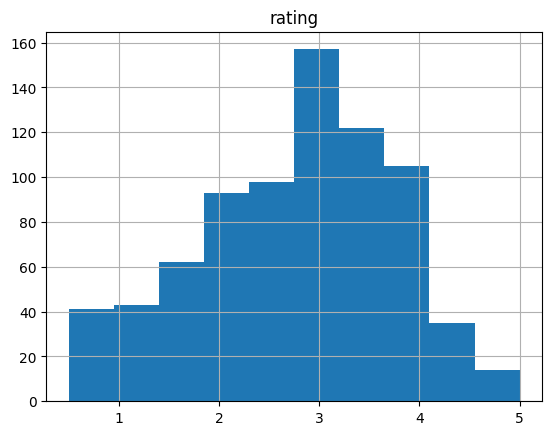

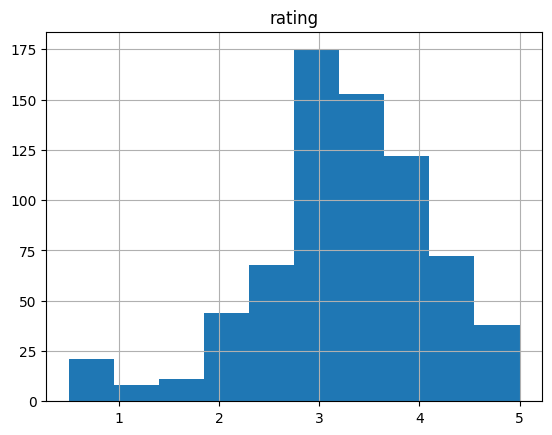

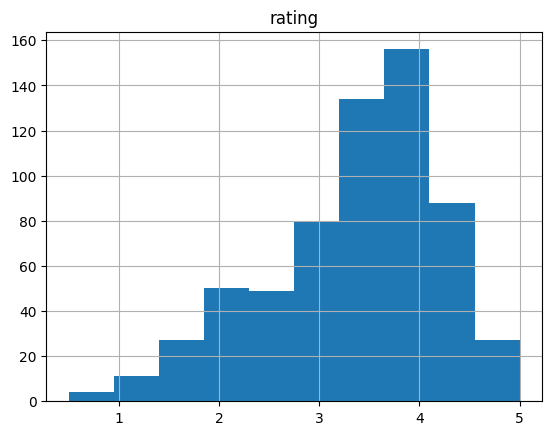

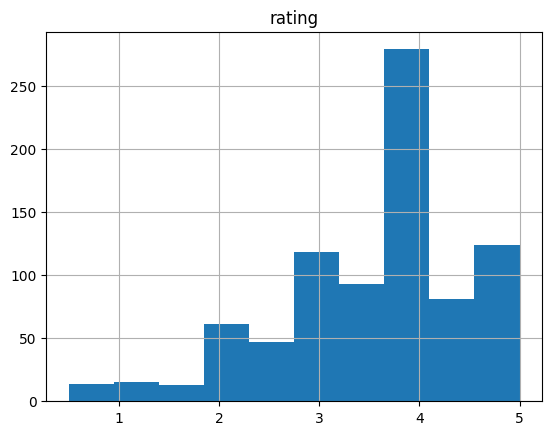

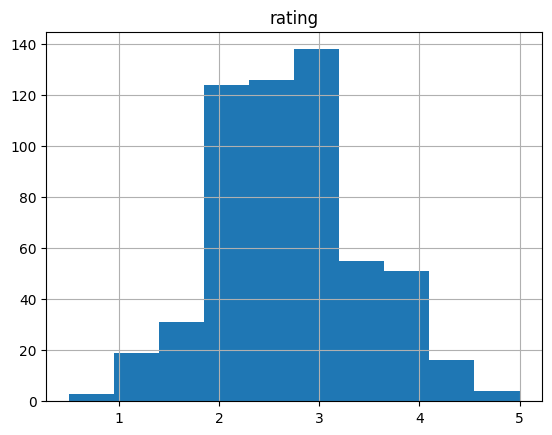

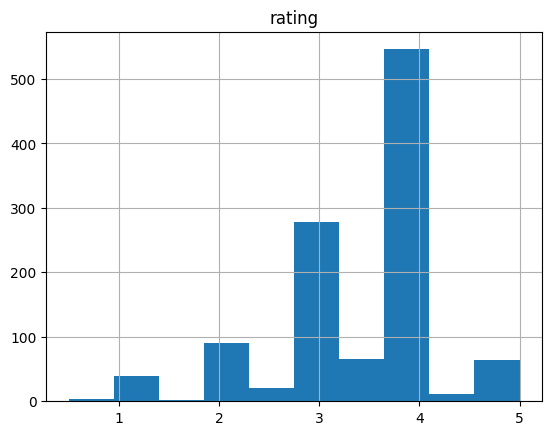

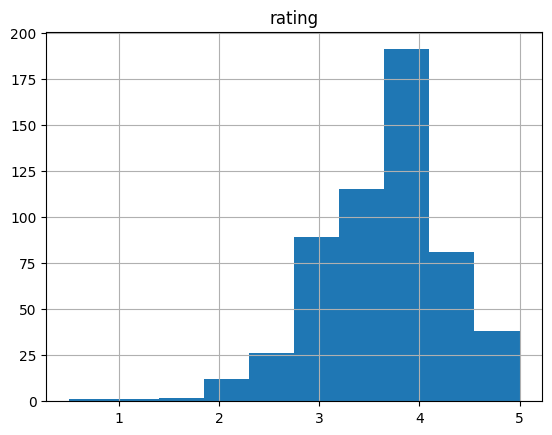

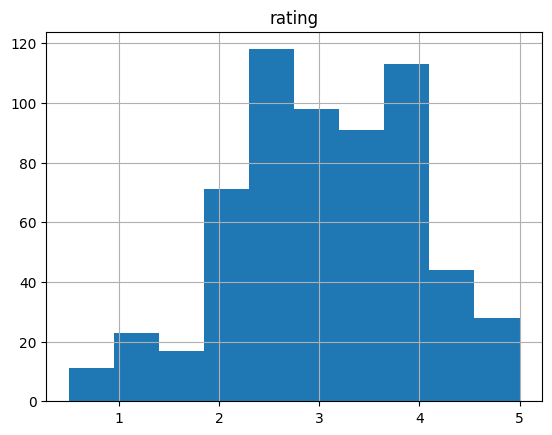

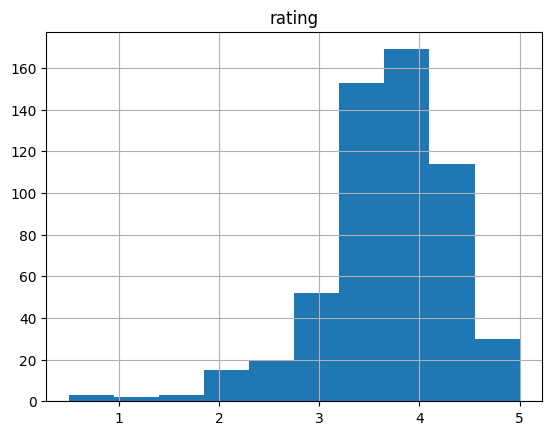

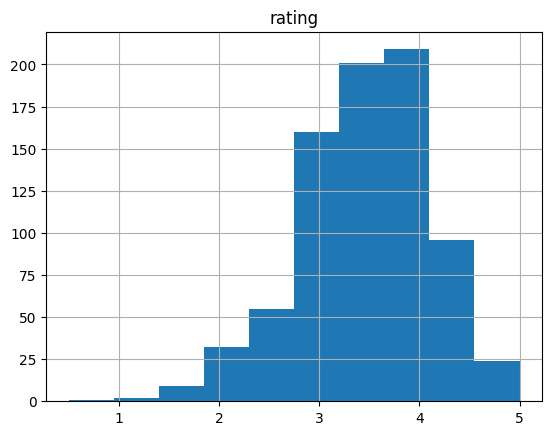

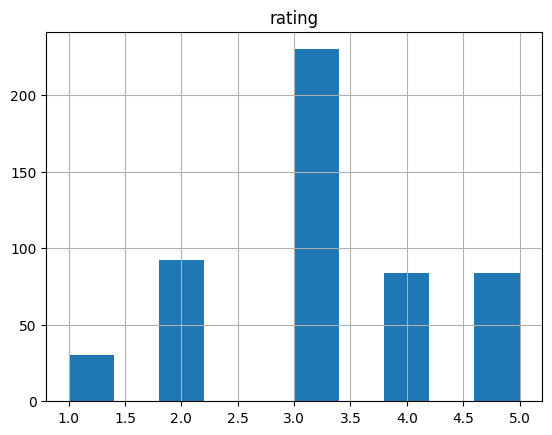

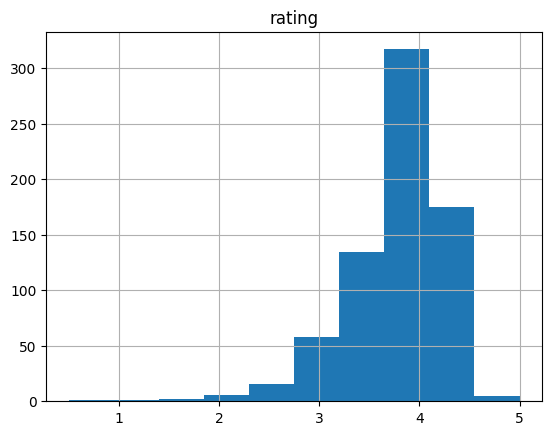

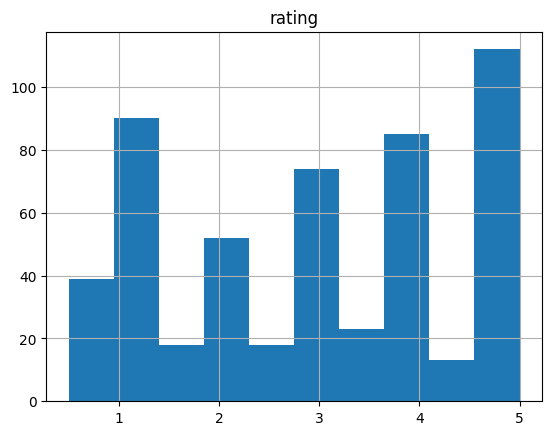

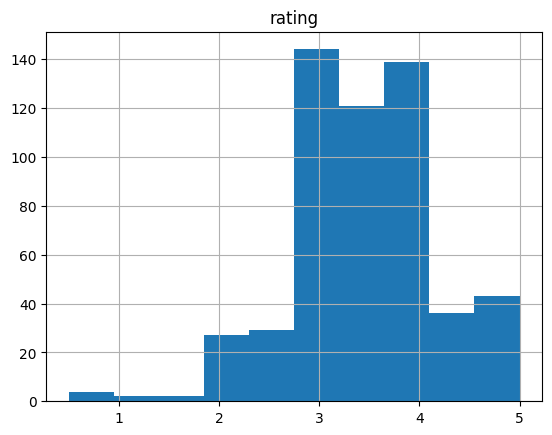

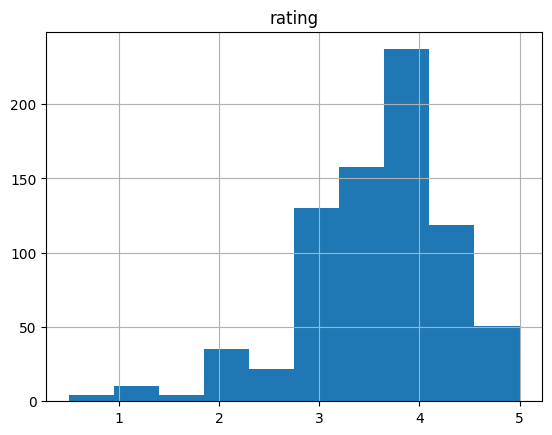

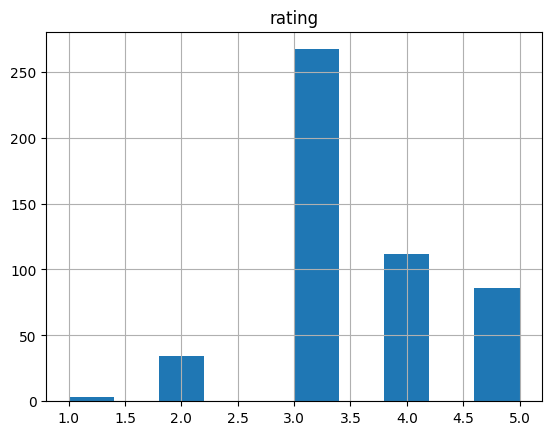

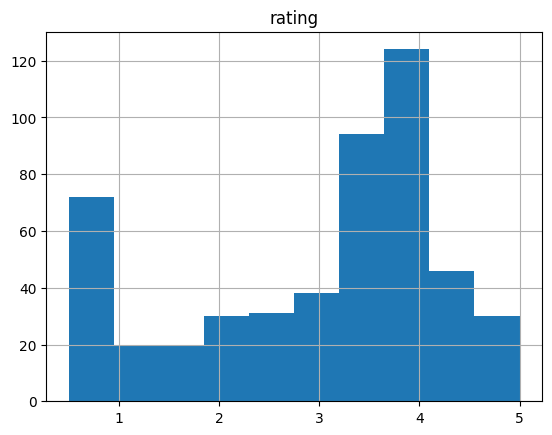

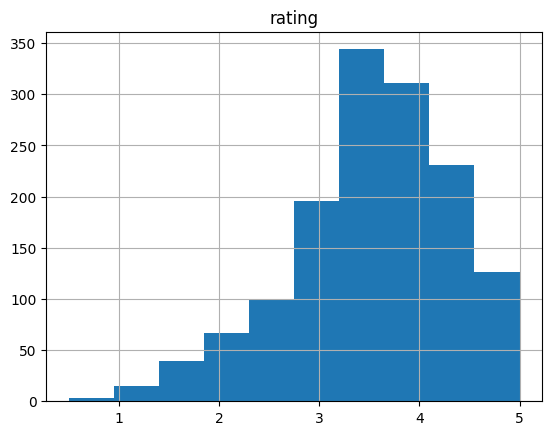

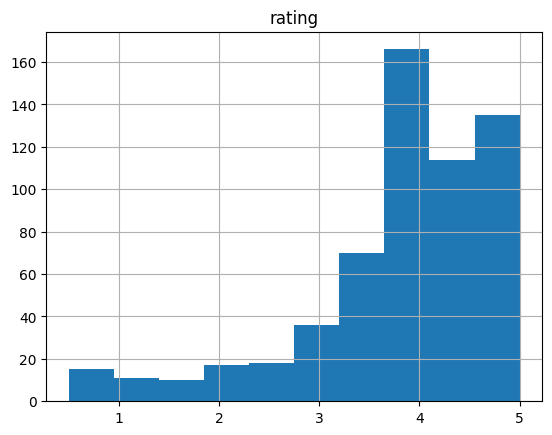

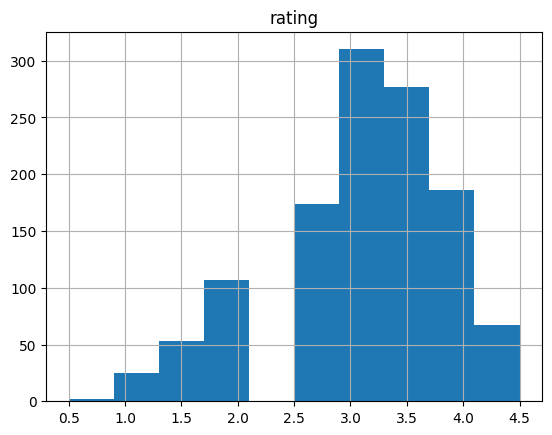

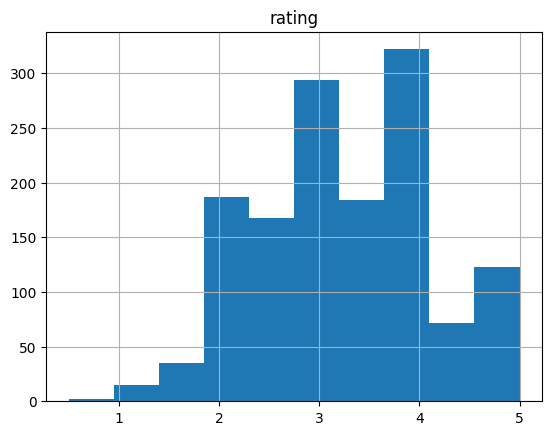

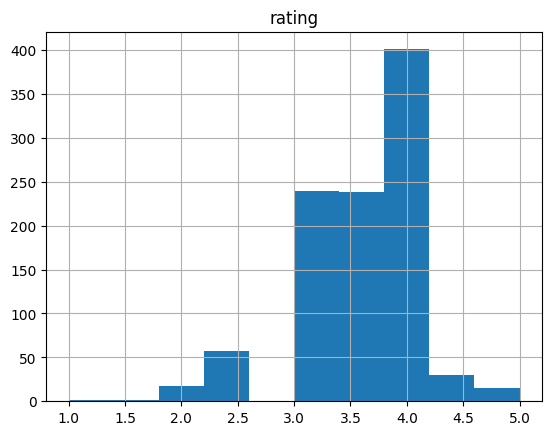

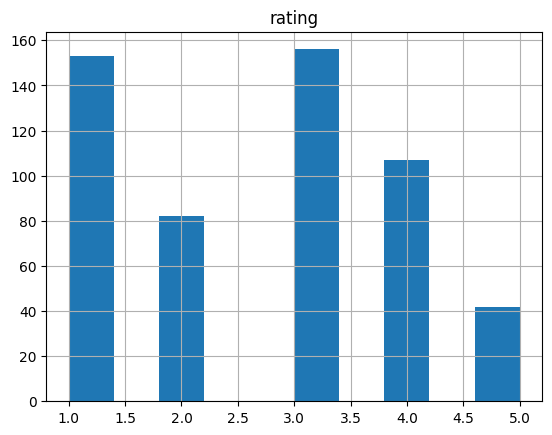

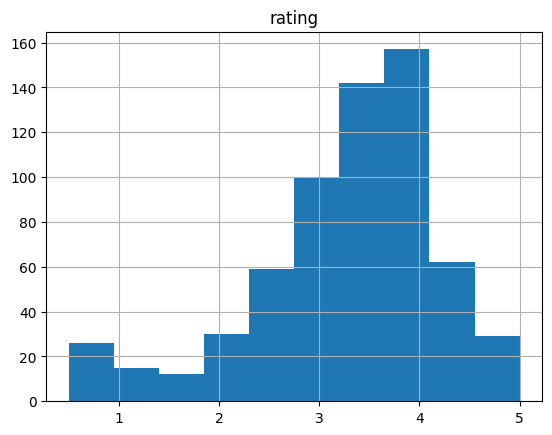

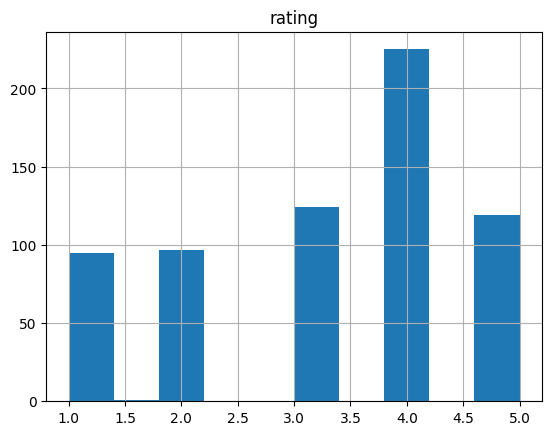

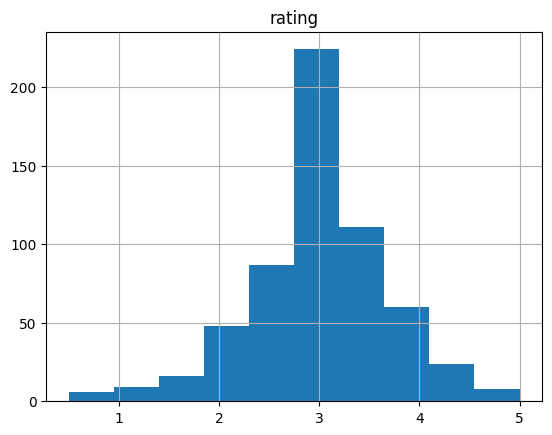

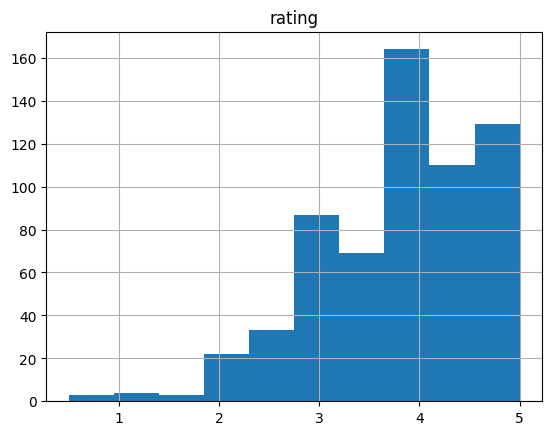

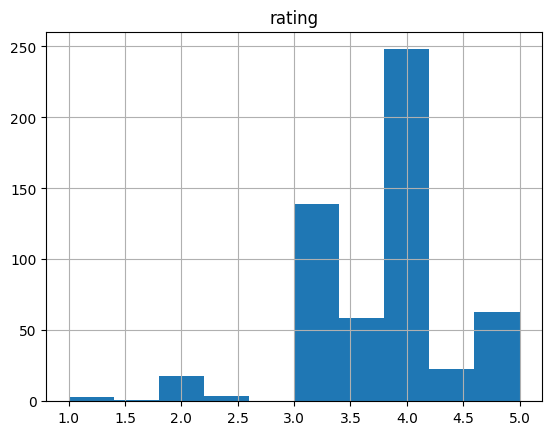

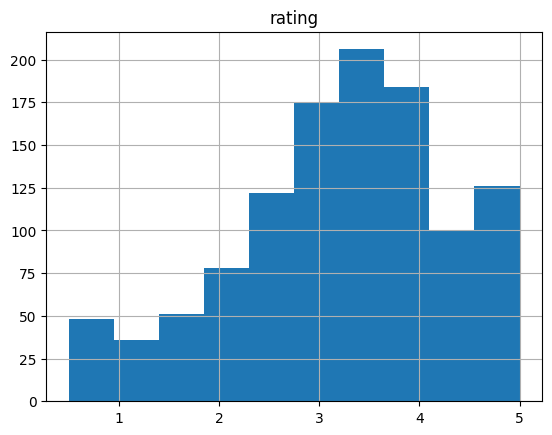

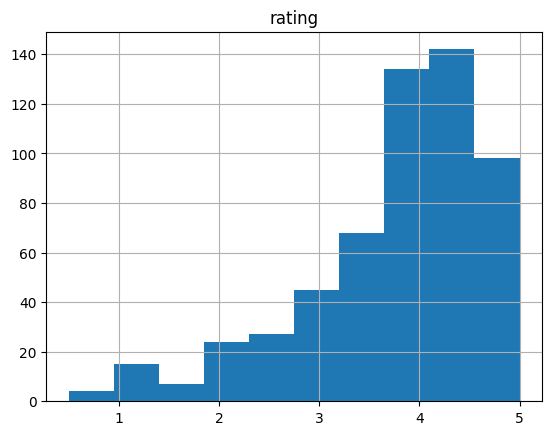

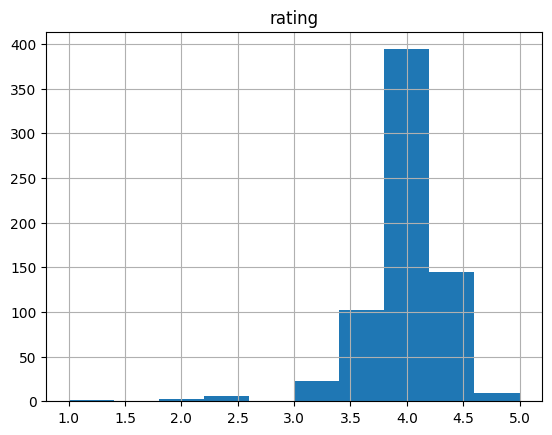

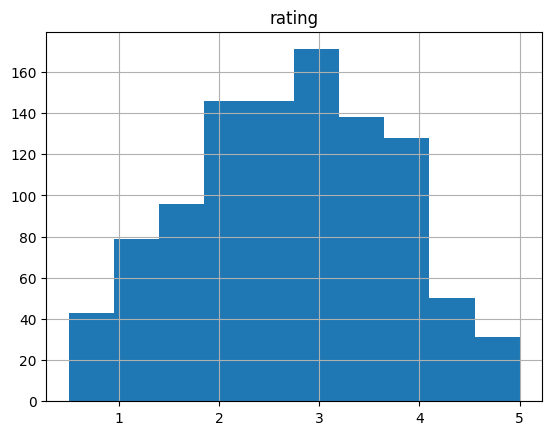

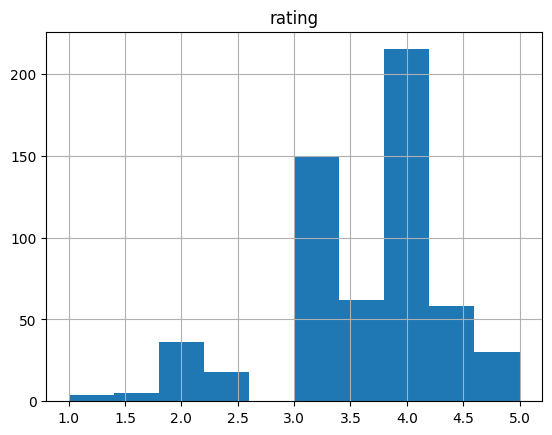

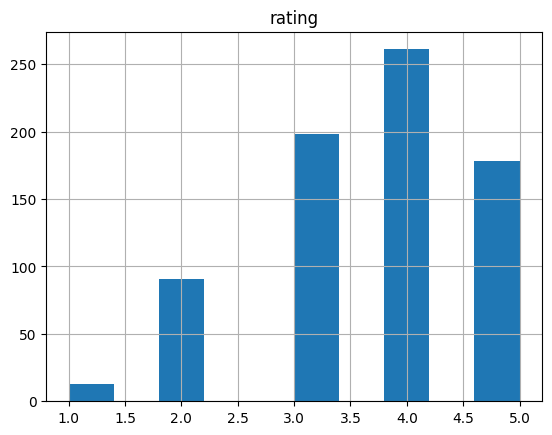

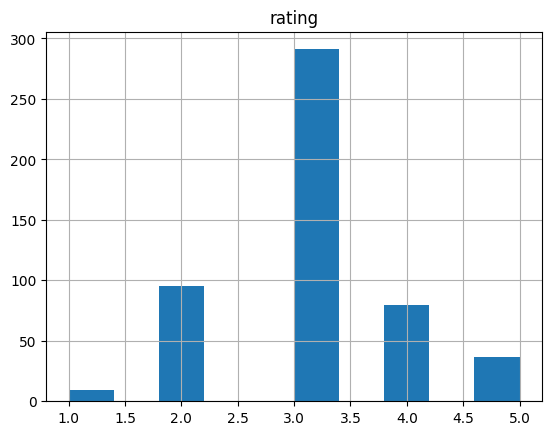

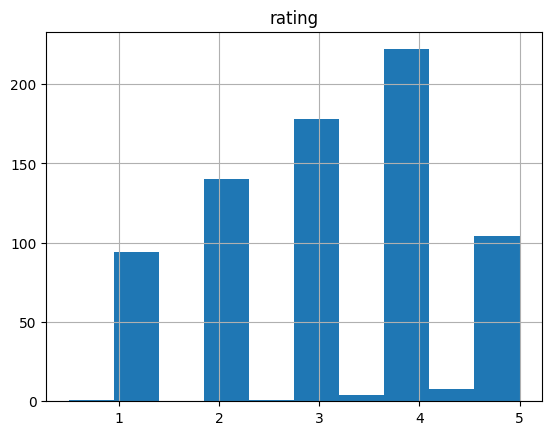

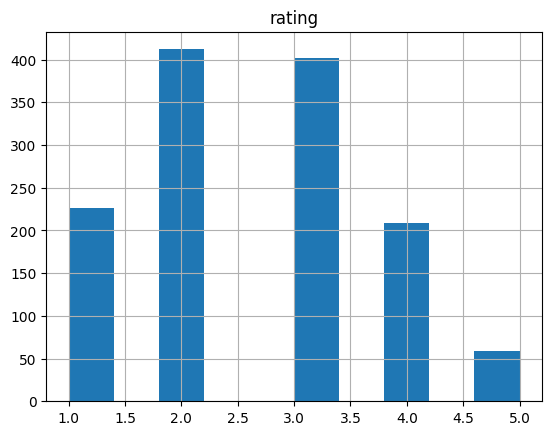

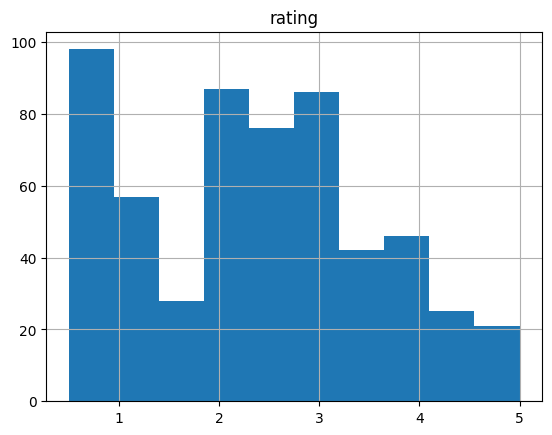

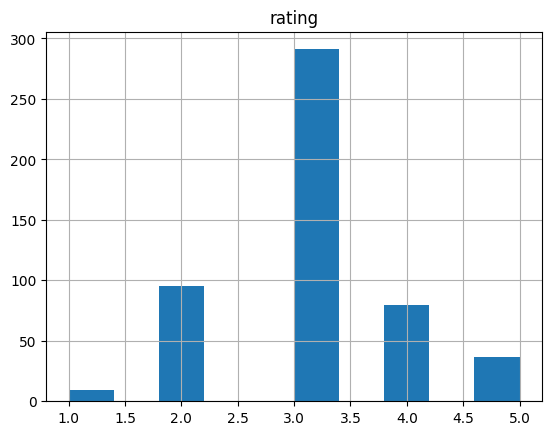

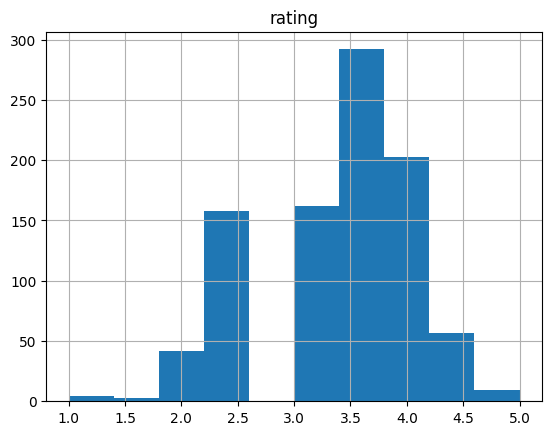

In [7]:
import numpy as np
for seed in np.arange(40):
    rng = np.random.RandomState(seed)
    user_id = rng.choice(df['userId'].unique())
    df_tmp = df[df['userId'] == user_id]
    print(df_tmp.shape[0])
    df_tmp.hist(column='rating')